In [1]:
import numpy as np
import os
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
# plt.style.use('seaborn')
import matplotlib.patches as mpatches
from matplotlib import colors

%matplotlib inline

In [2]:
### LOAD & ASSIGN DATA
df = pd.read_excel('Data/All_paleocurrents.xlsx') # load data, MAKE SURE FILE WINDOW IS CLOSED

col_type = 'Type' ## Column name containing the indicator type
col_dir = 'Direction' ## Column name containing the paleocurrent directions

df[col_dir] = df[col_dir].astype('int')

In [3]:
### INPUT
# print(df[col_type].unique()) #Toggle this to print the unique type names in your datasheet
stacked = True #If set to True: indicator types will be stacked in the plot. If set to False: indicator types will start from origin as overlain plots

types = ['imbrication',
         'ripple',
         'flute'] #Categories you want to sort the data
filtr = ['imbr',
         'rip|foreset',
         'flute'] #Labels that represent the above categories in your datasheet. Should match in number and oreder of terms
auto_sort = 'normal' #If set to 'normal': types will be sorted by counts, smallest to largest. If set to 'reverse': types will be sorted by counts, largest to smallest. Any other input will revert to the order of the input list above.

bins = 16 #Set the number of bins

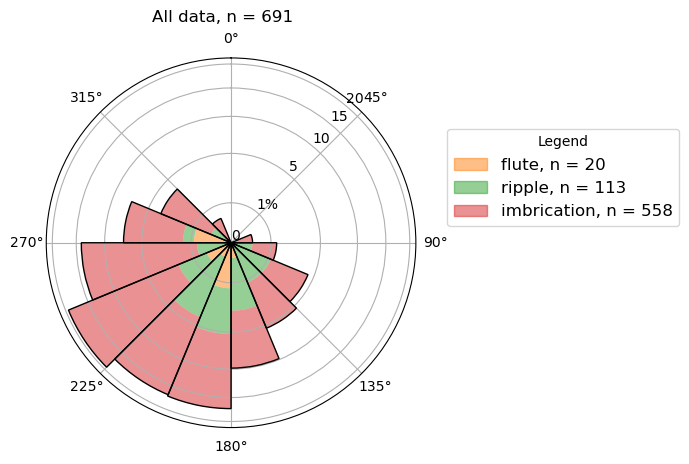

In [4]:
### PROCESSING & PLOTTING
## Convert measurement types to general classes
for x,y in zip(types,filtr):
    df.loc[df[col_type].str.contains(y), 'type_gen'] = x

bin_int = 360/bins

fig= plt.figure()

## Plot all data as base
directions = df[col_dir].to_numpy()
bin_classes = []
binn = []
counts_tot = []
counts_perc = []
for x in range(bins):
    #Define bin limits:
    bin_classes.append(((x*bin_int),((x+1)*bin_int)))
    #Seperate the measurements into bins, using a ≤ x < b :
    binn.append(np.array([(directions[(directions >= (x)*bin_int) & (directions < (x+1)*bin_int)])]))
    #Count how many values in each bin, using a ≤ x < b :
    counts_tot.append(np.count_nonzero((directions >= (x)*bin_int) & (directions < (x+1)*bin_int))) 
#Convert number of counts to percentage of total counts in each bin:
for x in counts_tot:
    counts_perc.append(x/sum(counts_tot)*100)
### Plotting with equal area
### Ploting with dataset-dependent radius
### Calculate the unit radius (r_1%), depending on largest bin:
r_unit = max(counts_perc)/math.sqrt(max(counts_perc))
### Calculate radii corresponding to each bin, using r_f% = r_1% * f%^0.5:
radii = []
for x in counts_perc:
    radii.append(r_unit * math.sqrt(x))
### Define r or y axis tickmarks:
r_ticks = [r_unit]
r_tickslabels = ['1%']
r_ticksinterval = 5 #Sets the spacing between radius ticks
for x in range(0,int(max(counts_perc))+r_ticksinterval,r_ticksinterval):
    r_ticks.append(r_unit*math.sqrt(x))
    r_tickslabels.append(x)
theta = np.linspace(0.0, 2 * np.pi, bins, endpoint=False)+(np.pi/bins) #Last bracketed term sets of the bin starting point
width = (2*np.pi)/bins #Calculates bin width depending on number of bins
ax = plt.subplot(111, projection='polar')
ax.bar(theta, radii, width=width, bottom=0.0, fill=False, edgecolor='black', linewidth=1, zorder=10) #Plots equal-area
ax.set_theta_zero_location("N")  # theta=0 at the top
ax.set_theta_direction(-1)  # theta increasing clockwise
ax.set_yticks(r_ticks)
ax.set_yticklabels(r_tickslabels)
ax.set_rlabel_position(40)  # Move radial labels away from plotted line
plt.suptitle('All data, n = ' + str(len(directions)))

## Sort the type list from smallest to largest group for plotting
if auto_sort == 'normal': types = df.groupby('type_gen').size().sort_values().index.tolist()
if auto_sort == 'reverse': types = df.groupby('type_gen').size().sort_values(ascending=False).index.tolist()
if stacked == False: types.reverse() #For non-stacked charts, reversing the sorted list will result in the correct drawing order to prevent overlapping

## Plot the subtypes
bottom = np.zeros(bins) #Set the starting point for the radial bars at origin (0.0)
counts_perc = np.zeros(bins)
colors = []
type_labels = []
for z in types:
    directions = df[df['type_gen'].str.contains(z)][col_dir].to_numpy()
    binn = []
    counts = []
    counts_perc1 = []
    radii = []
    for x in range(bins):
        #Seperate the measurements into bins, using a ≤ x < b :
        binn.append(np.array([(directions[(directions >= (x)*bin_int) & (directions < (x+1)*bin_int)])]))
        #Count how many values in each bin, using a ≤ x < b :
        counts.append(np.count_nonzero((directions >= (x)*bin_int) & (directions < (x+1)*bin_int))) 
    #Convert number of counts to percentage of total counts in each bin:
    for x in counts:
        counts_perc1.append(x/sum(counts_tot)*100)
    counts_perc = [x + y for x, y in zip(counts_perc, counts_perc1)] if stacked == True else counts_perc1 #Calculate radius extent for this class by summing counts with previous classes
    ### Plotting with equal area
    ### Ploting with dataset-dependent radius
    ### Calculate radii corresponding to each bin, using r_f% = r_1% * f%^0.5:
    for x in counts_perc:
        radii.append(r_unit * math.sqrt(x))
    radii_portion = [x - y for x, y in zip(radii, bottom)] if stacked == True else radii #Calculate the radius to add to the bottom value for each bin, in order to plot to the true radius
    theta = np.linspace(0.0, 2 * np.pi, bins, endpoint=False)+(np.pi/bins) #Last bracketed term sets of the bin starting point
    a = plt.bar(theta, radii_portion, width=width, bottom=bottom, alpha=0.5) #Plots equal-area
    colors.append(a[0].get_facecolor())
    type_labels.append(z + ', n = ' + str(len(directions)))
    bottom = radii if stacked == True else 0.0 #Set the starting point for the bars on top of previous class

## Format legend
cmap = dict(zip(types, colors))
patches = [Patch(color=v, label=k) for k,v in cmap.items()]
plt.legend(title='Legend', labels=type_labels, handles=patches, bbox_to_anchor=(1.04, 0.5), loc='lower left', borderaxespad=1, fontsize=12, frameon=True)
    
plt.show()
# fig.savefig('Baja_combined_paleocurrents_stacked.svg')